#### Source Files
1. Salesforce SaleRep Lead pref - Oppty
    - https://d300000001vgeeau.my.salesforce.com/00O4y000003xWkb
1. Salesforce SaleRep Lead pref - Deal
    - https://d300000001vgeeau.my.salesforce.com/00O4y000003xWkq


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas()

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#### Business Question
1. What are the top practice area getting deals?
    1. Who are the sales rep getting this deals?
    1. What are their position level?
1. What are the type of leads getting deals?

In [2]:
class dataframe_deals:
    def __init__(self, link):
        self.df = pd.read_csv(link, encoding = 'latin-1')
        self.df.dropna(subset = ['Deal: Deal Name'], inplace = True)
        self.df['Order Date'] = pd.to_datetime(self.df['Order Date'])
        self.practice_area_count()
    
    def practice_area_count(self):
        list = [x for x in self.df.columns if 'Area of Practice' in x]
        self.df['Count of Practice Area'] = self.df.apply(lambda x: 5 - x[list].isna().sum(), axis = 1)
    
    def PA_table(self):
        list = [x for x in self.df.columns if 'Area of Practice' in x]
        list.extend(['Deal: ID', 'Order Date'])
        return self.df[list].melt(id_vars = ['Deal: ID', 'Order Date']).dropna(subset = ['value'])
        

In [3]:
deals = dataframe_deals('raw/salesforce salesrep lead pref - deal.csv')

#### Deals per Practice Area

In [4]:
test = deals.PA_table()

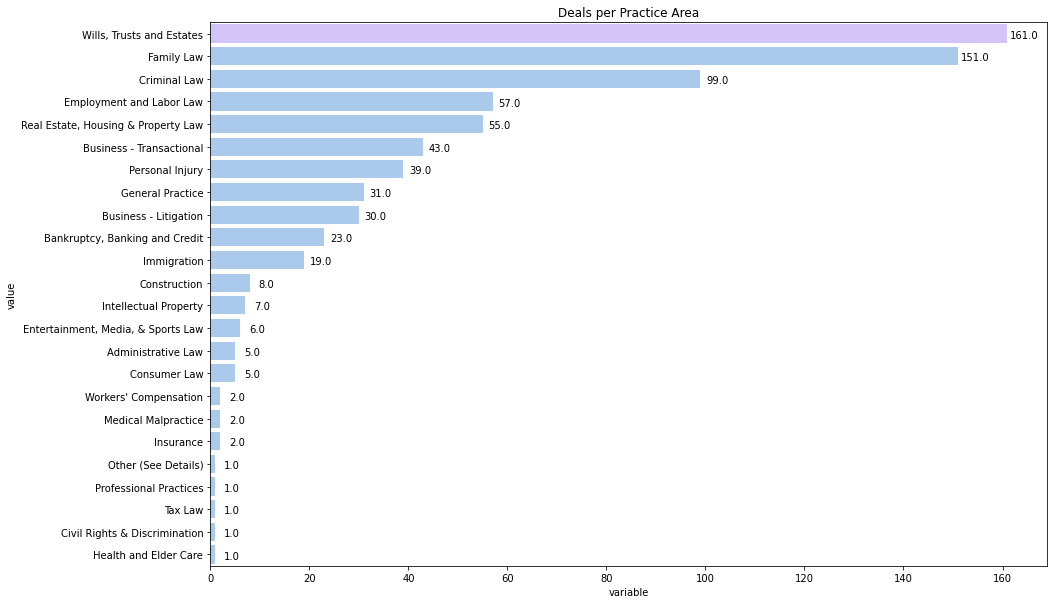

In [5]:
df = test.pivot_table(index = ['value'], values = 'variable', aggfunc = 'count').sort_values(by ='variable', ascending = False)

colors = sns.color_palette('pastel')
colors = [colors[0] if df.loc[df.index[x], 'variable'] !=  df.variable.max() else colors[4] for x in range(len(df.index))]
plt.figure(figsize = (15,10))
ax = sns.barplot(data = df, y = df.index, x = 'variable', palette = colors)
for bar in ax.patches:
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    ax.annotate(format(bar.get_width(), ','),
                   (bar.get_width() + 5,
                    bar.get_y() + bar.get_height()), ha='center', va='center',
                   size=10, xytext=(-8, 8),
                   textcoords='offset points')
_ = plt.title("Deals per Practice Area")

In [6]:
class dataframe_oppty:
    def __init__(self, link):
        self.df = pd.read_csv(link, encoding = 'latin-1')
        
    def auto_run(self):    
        self.data_preparation()
        self.lead_source_filter()
    
    def datetime(self, list):
        for x in list:
            self.df[x] = pd.to_datetime(self.df[x])
    
    def measureit(method):
        '''using a decorator to measure the before and after of dataframe length'''
        def measured(self):
            initial_len = len(self.df)
            result = method(self)
            final_len = len(self.df)
            return result
        return measured            

    @measureit
    def lead_source_filter(self):
        """Removing all types of renewal from the dataset"""
        remove_values = [x for x in self.df['Lead Source'].unique() if 'renewal' in str(x).lower()]
        self.df = self.df[~self.df['Lead Source'].isin(remove_values)]
        
    @measureit
    def data_preparation(self):
        self.df.dropna(subset = ['Process Tracking For'], inplace = True)
        self.datetime(['Created Date', 'Case Review Set', 'Case Review Completed', 'Enrollment Meeting Set'])
        self.filter_list = ['Test Calm Test',
                            'test opp - 3.17.22',
                            'test opp 4.19.22',
                            'Test Calm Test',
                            'Test',
                            'test opp 2.4.22',
                            'test']
        self.df = self.df[~self.df['Opportunity Name'].isin(self.filter_list)]                    
        
    def checker(method):
        def nan_checker(*arg, **kwargs):
            if str(arg) != 'nan':
                return method
            else:
                return np.nan
        return nan_checker
    
    def breaking_practice_areas(self):
        def splitter(string_to_list):
            if str(string_to_list) != 'nan':
                return str(string_to_list).split(';')
            else:
                return [np.nan]
        
        self.df['Practice Areas - list'] = self.df.apply(lambda x: splitter(x['Practice Areas']), axis = 1)
        self.df['Practice Areas - Length'] = self.df.apply(lambda x: len(x['Practice Areas - list']) if str(x['Practice Areas - list']) != 'nan' else np.nan, axis = 1)      
        
        

In [7]:
oppty = dataframe_oppty('raw/salesforce salesrep lead pref - oppty.csv')
oppty.auto_run()

In [8]:
oppty.breaking_practice_areas()

In [9]:
practice_areas = pd.DataFrame(oppty.df['Practice Areas - list'].tolist(), index = oppty.df.index)

In [10]:
practice_areas.columns = ["Practice Area " + str(x + 1) for x in practice_areas.columns]

In [11]:
practice_areas.reset_index(drop = False, inplace = True)
practice_areas = practice_areas.melt(id_vars= 'index').dropna()

In [12]:
practice_areas.set_index('index', inplace = True)

In [13]:
# get the practice are of deals and who are the process tracking fors
# also check location/state of the deals where they are located
# Check the position level of the rep during the deal

# plan to present this in heatmap format

In [14]:
df = oppty.df.merge(practice_areas, left_index= True, right_index= True)

In [15]:
df_deal = df[df['Stage'] == 'Deal']

#### Insights:
1. Highest lead source is still self gen leads
1. Check which leads can be breakdowned with email campaign
    - Possible: HOTLEAD-Calendly

# Deal Count based on Position and Practice Areas

In [16]:
# position_deal = df_deal.pivot_table(index = 'CR Set Position', columns = 'value', values = 'Opportunity Name', aggfunc = 'count')
position_deal = df_deal.pivot_table(index = 'CR Completed Position', columns = 'value', values = 'Opportunity Name', aggfunc = 'count')

In [17]:
position_deal['Total'] = position_deal.sum(axis = 1)

In [18]:
position_deal.reset_index(drop = False, inplace = True)

In [19]:
position_mapping = {
    'AMRM1':'AMRM', 'AMRM2':'AMRM', 'Associate Director':'AD', 'BDR-AMRM1':'BDR-AMRM', 'BDR2-AMRM2':'BDR-AMRM',
    'Director of Training & Development':'Trainer', 'MRM':'MRM', 'MRM Trainer':'Trainer', 'MRM1':'MRM',
    'MRM2':'MRM', 'MRM3':'MRM', 'NMRM':'NMRM', 'Remote AMRM1':'Remote AMRM', 'Remote AMRM2':'Remote AMRM', 'SMRM':'SMRM', 'SMRM1':'SMRM',
    'SMRM2':'SMRM', 'SMRM3':'SMRM', 'SMRM4':'SMRM', 'Sales Director':'Director', 'Senior MRM':'SMRM', 'Site Director':'Director'
}

In [20]:
position_deal['Clean Position'] = position_deal.apply(lambda x: position_mapping[x['CR Completed Position']], axis = 1)
# position_deal['Clean Position'] = position_deal.apply(lambda x: position_mapping[x['CR Set Position']], axis = 1)

In [21]:
position_deal.drop(columns = ['CR Completed Position', 'Total'], inplace = True)
# position_deal.drop(columns = ['CR Set Position', 'Total'], inplace = True)
# position_deal.set_index('Clean Position', inplace = True)

In [22]:
position_deal = position_deal.pivot_table(index = 'Clean Position', aggfunc = np.sum)

In [23]:
sort_order = ['Remote AMRM', 'BDR-AMRM', 'AMRM', 'MRM', 'NMRM', 'SMRM', 'AD', 'Director','Trainer']

position_deal = position_deal.reindex(sort_order)

In [24]:
position_deal_transposed = position_deal.T

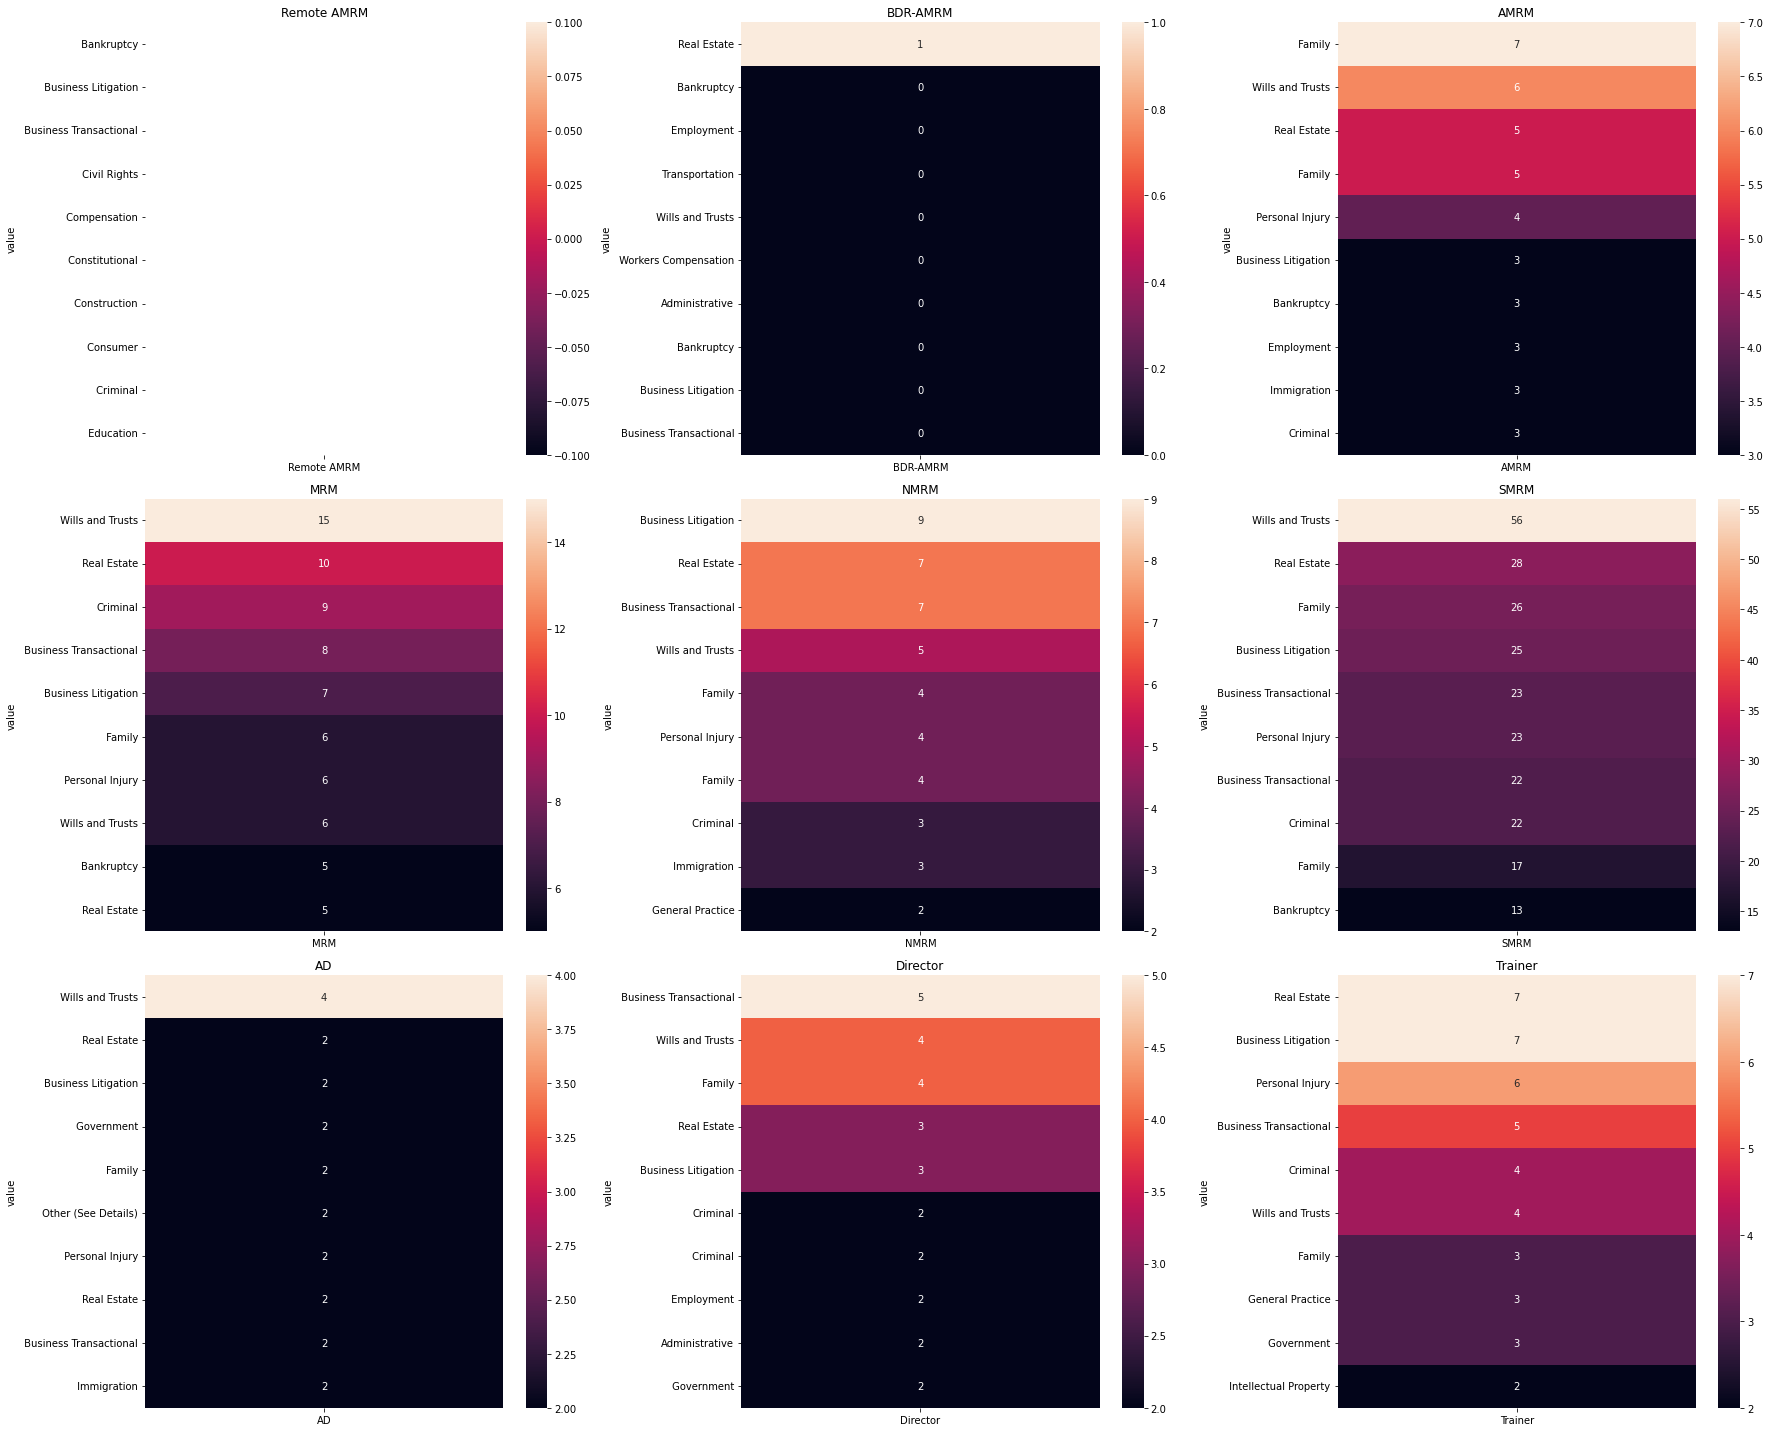

In [25]:
plt.figure(figsize=(25, 20))
plot_number = 1
for column in position_deal_transposed:
    # print(column)
    plt.subplot(3, 3, plot_number)
    sns.heatmap(position_deal_transposed[[column]].sort_values(by = column, ascending = False).head(10), annot= True)
    plt.title(column)
    plt.xlabel("")
    plt.tight_layout()
    plot_number += 1

1. BDR did not generate any deals
1. Verify with Matt if it is correct reference Position on case review completed position

#### Sales Rep Experince per lead Type

In [62]:
# need to check the lead source type
verification = df_deal.loc[~df_deal['CR Completed Position'].isna()]

verification['lead Source - Type'] = verification[['Lead Source' , 'Lead Source Type']].apply(lambda x: str(x['Lead Source']) + ' - ' + str(x['Lead Source Type']), axis = 1)
verification['CR Completed Position'] = verification.apply(lambda x: position_mapping[x['CR Completed Position']], axis = 1 )

In [63]:
verification = verification.pivot_table(columns = 'lead Source - Type', index = 'CR Completed Position', values = 'Opportunity Name', aggfunc= 'count').reindex(sort_order).T

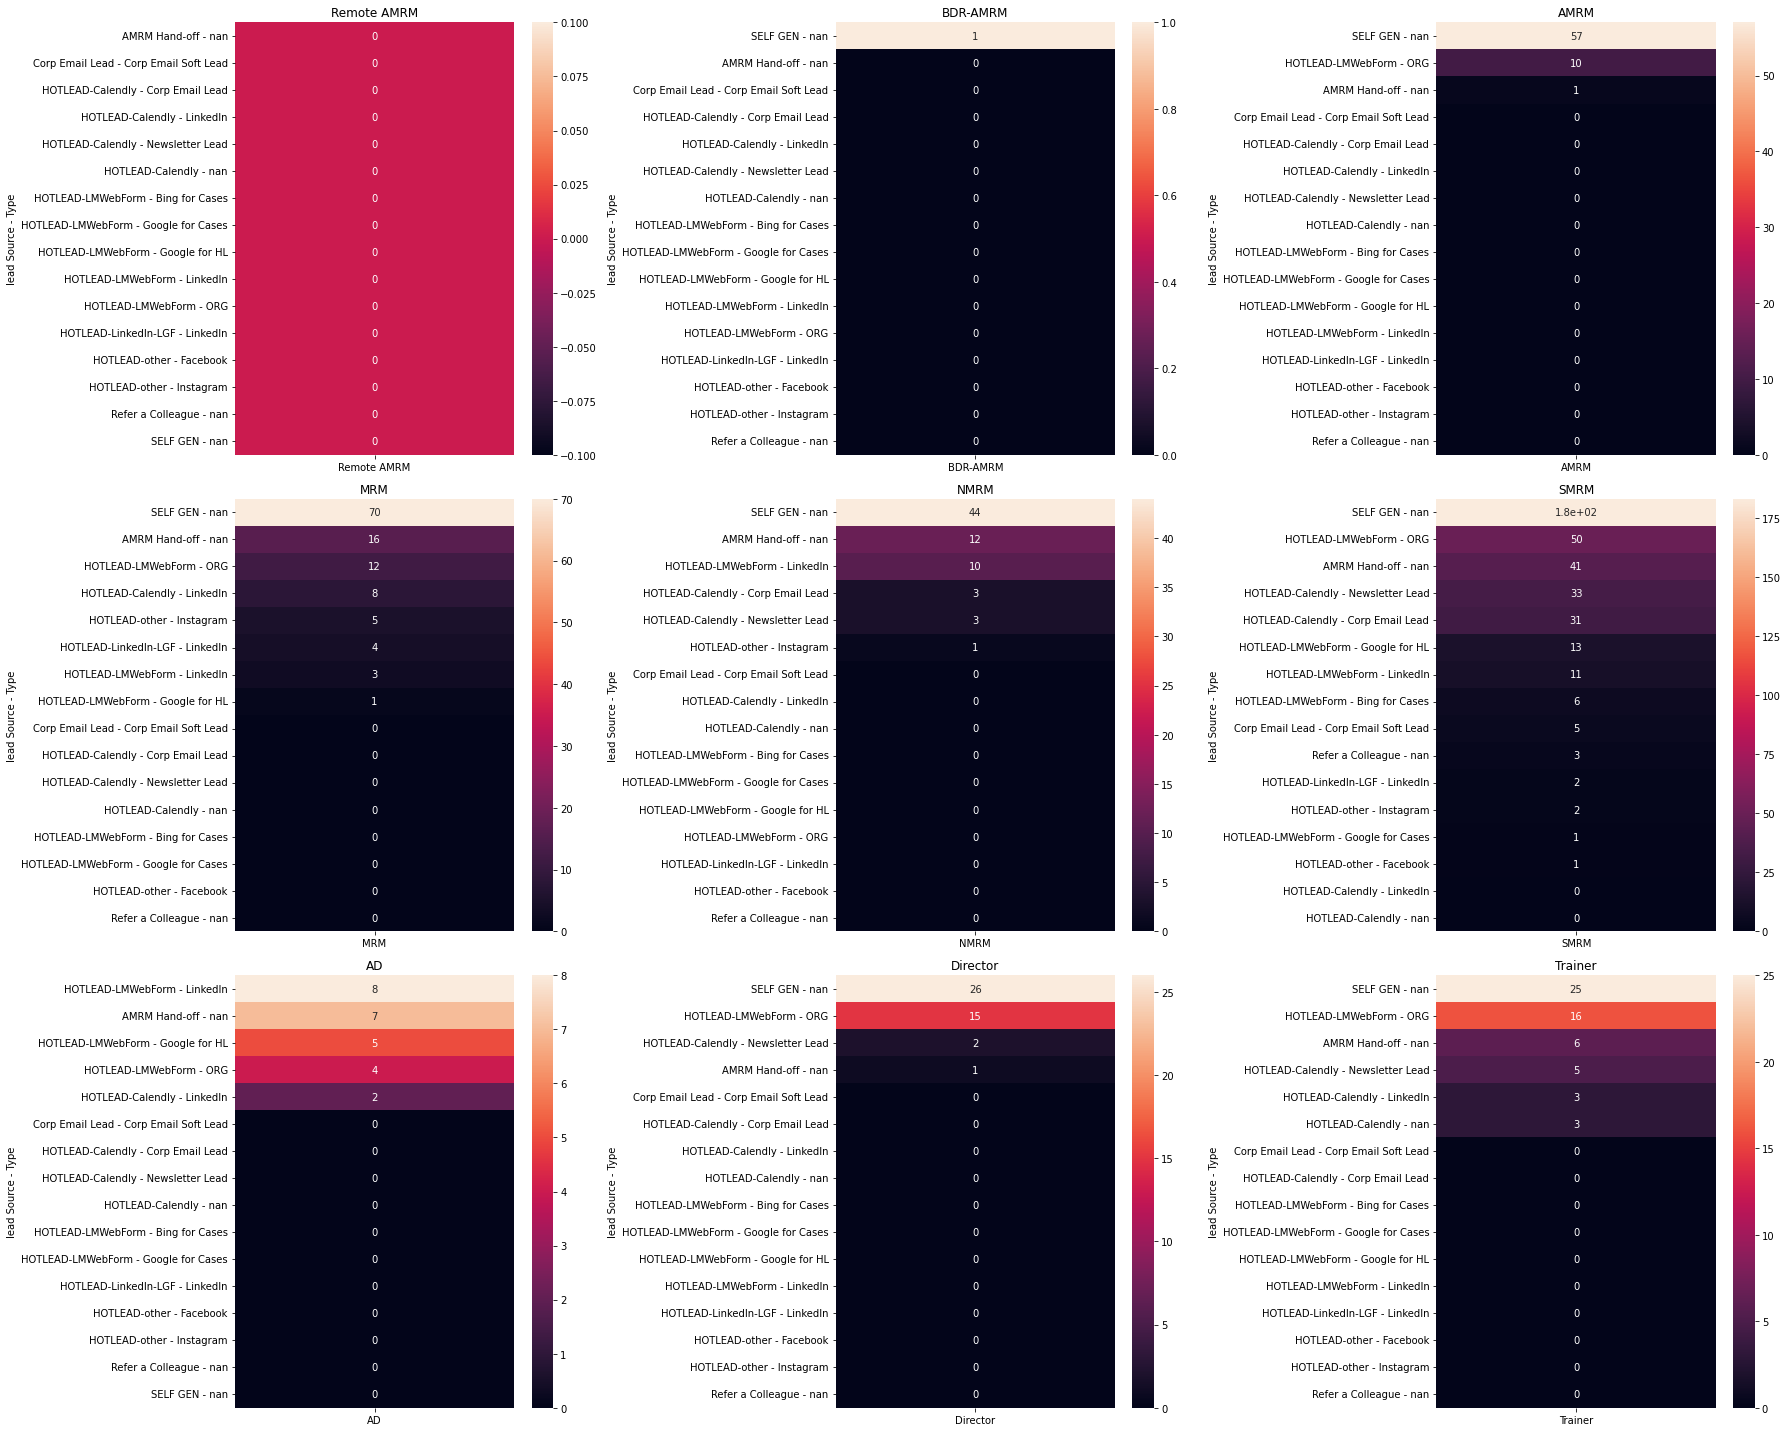

In [64]:
plt.figure(figsize= (25,20))
plot_number = 1
for column in verification:
    plt.subplot(3, 3, plot_number)
    sns.heatmap(verification[[column]].sort_values(by = column, ascending = False).fillna(0), annot= True)
    plt.title(column)
    plt.xlabel("")
    plt.tight_layout()
    plot_number += 1

In [65]:
for column in verification:
    verification[column] = (verification[column] / verification[column].sum())

In [70]:
verification.drop(columns = ['Remote AMRM'], inplace = True)

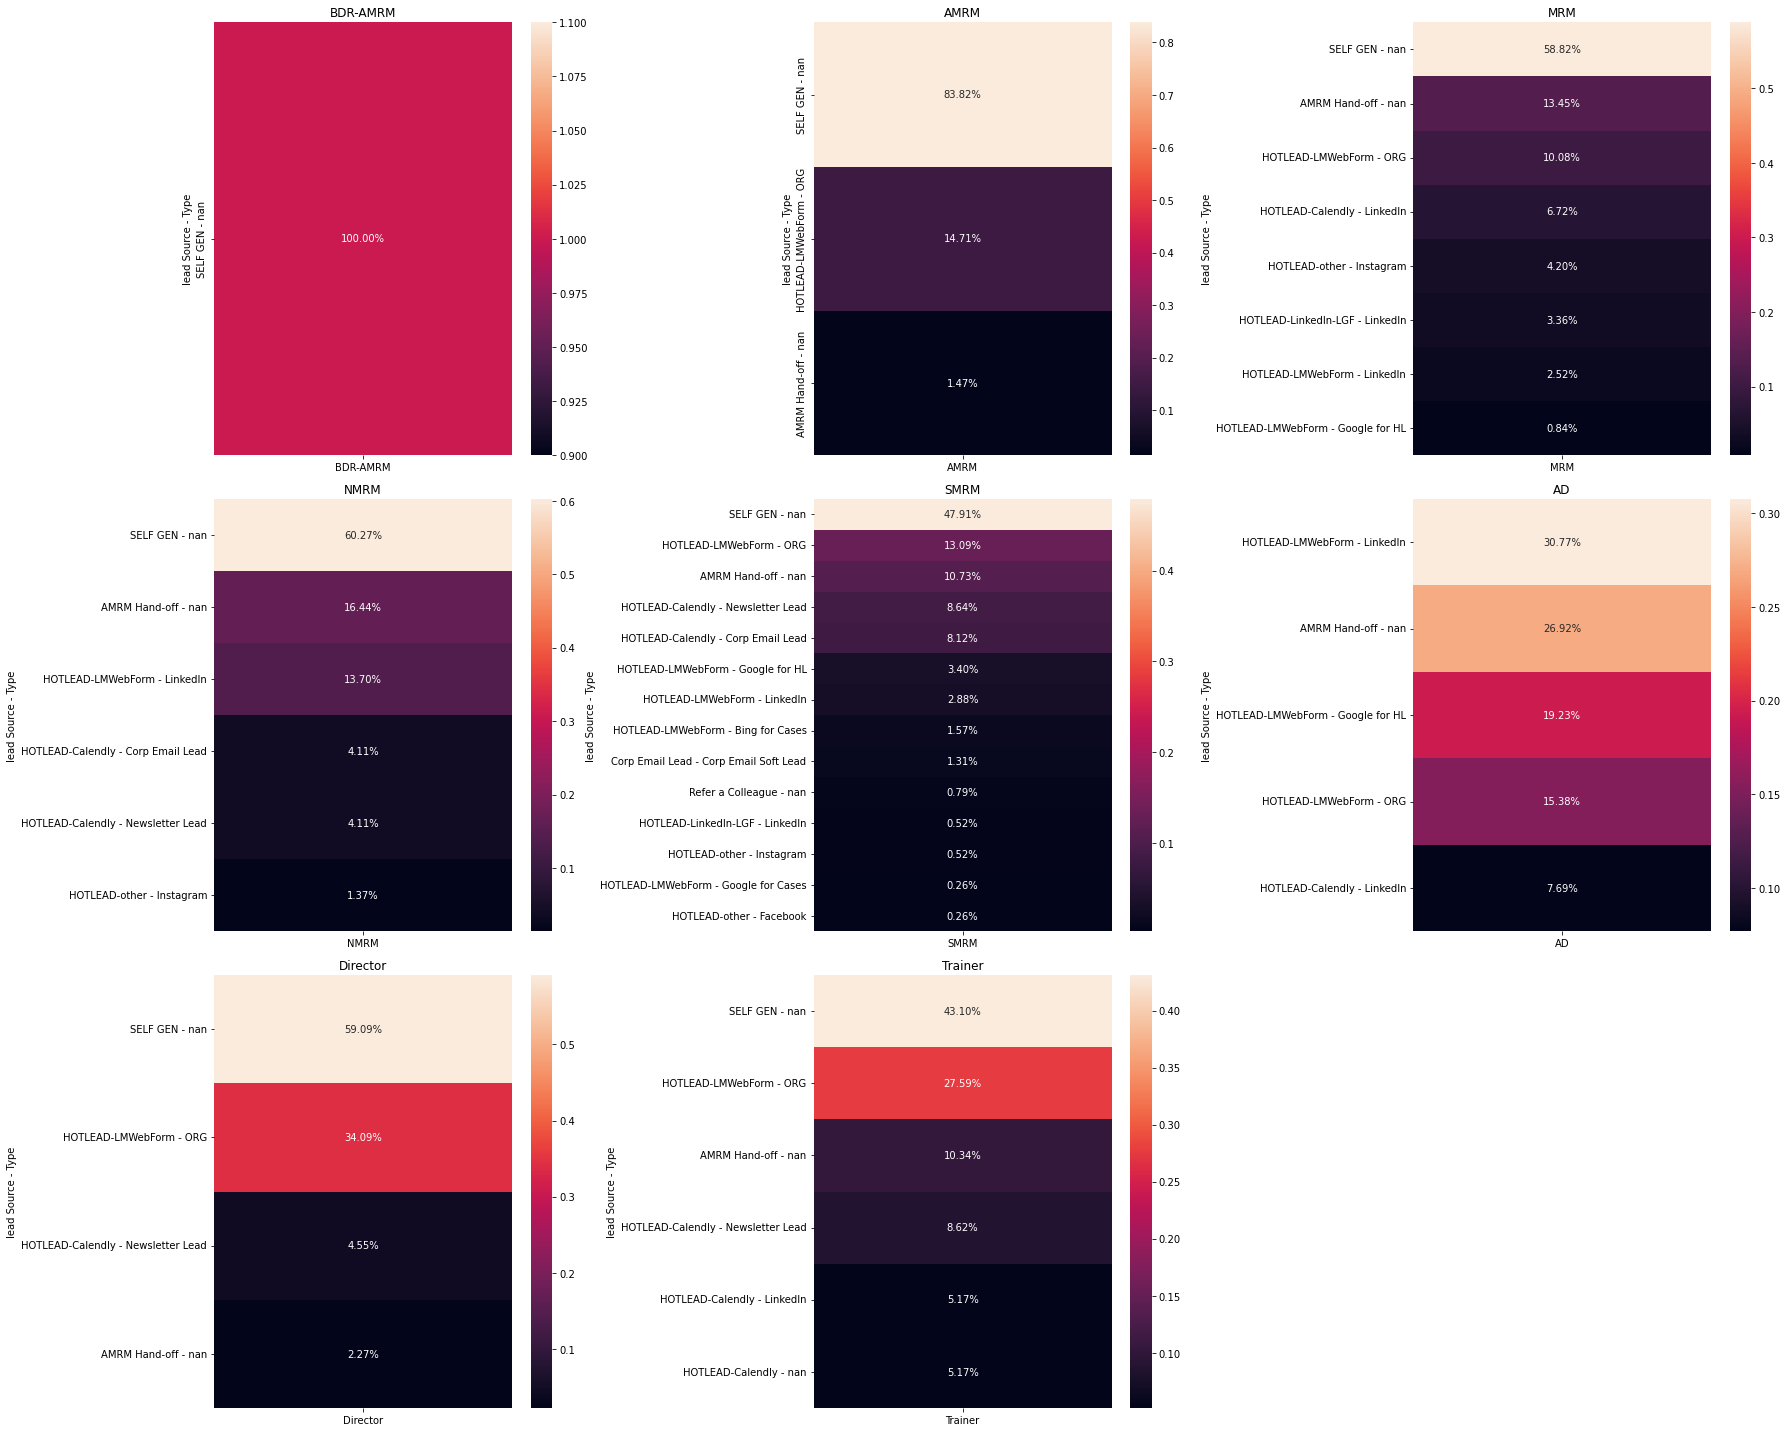

In [71]:
plt.figure(figsize= (25,20))
plot_number = 1
for column in verification:
    plt.subplot(3, 3, plot_number)
    sns.heatmap(verification[[column]].sort_values(by = column, ascending = False).dropna(), annot= True, fmt = '.2%')
    plt.title(column)
    plt.xlabel("")
    plt.tight_layout()
    plot_number += 1